# Example: SN Light-Curve

Here we will work through an example to show the power of `caskade` in simplifying the process of developing an analysis routine. We will use a mock highly simplified supernova light curve fitting problem as our example. In this we will start with a simple analysis where we fit each light curve image separately, then we will use `caskade`'s parameter linking to join the data into a single likelihood, finally we will use function pointers to fit a light curve model rather than individual brightnesses. At each stage we will se how `caskade` makes it easy to build on past work and how it keeps track of all the parameters for us. The power of `caskade` is that it makes the development process easier so we don't need to rewrite code or redo work as our model of the problem grows in complexity!

In [1]:
import caskade as ck
import torch
import numpy as np
from torch.autograd.functional import hessian
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
from matplotlib import colormaps
from IPython.display import HTML
from scipy.optimize import minimize
import emcee

Below we define our Gaussian and Combined modules like before. Expand to see the details.

In [2]:
class Gaussian(ck.Module):
    def __init__(self, name, x0=None, y0=None, q=None, phi=None, sigma=None, flux=None):
        super().__init__(name)
        self.x0 = ck.Param("x0", x0) # position
        self.y0 = ck.Param("y0", y0)
        self.q = ck.Param("q", q) # axis ratio
        self.phi = ck.Param("phi", phi) # orientation
        self.sigma = ck.Param("sigma", sigma) # width
        self.flux = ck.Param("flux", flux) # total light

    @ck.forward
    def _r(self, x, y, x0=None, y0=None, q=None, phi=None):
        x, y = x - x0, y - y0
        s, c = torch.sin(phi), torch.cos(phi)
        x, y = c * x - s * y, s * x + c * y
        return (x ** 2 + (y * q) ** 2).sqrt()
    
    @ck.forward
    def brightness(self, x, y, sigma=None, flux=None):
        return flux * (-self._r(x, y)**2 / sigma**2).exp() / (2 * torch.pi * sigma**2).sqrt()
    
class Gaussian1D(ck.Module):
    def __init__(self, name, t0=None, sigma=None, peak_flux=None):
        super().__init__(name)
        self.t0 = ck.Param("t0", t0) # position
        self.sigma = ck.Param("sigma", sigma) # width
        self.peak_flux = ck.Param("peak_flux", peak_flux) # intensity

    @ck.forward
    def flux(self, t, peak_flux, t0, sigma):
        return peak_flux * (-((t + t0) / sigma)**2).exp()
    
class Combined(ck.Module):
    def __init__(self, name, x, y, models):
        super().__init__(name)
        self.x = x
        self.y = y
        self.models = models 

    @ck.forward
    def __call__(self):
        return sum(model.brightness(self.x, self.y) for model in self.models)
    
class Noiser(ck.Module):
    def __init__(self, name, model, read_noise=0.1, exp_time = 100):
        super().__init__(name)
        self.model = model
        self.read_noise = read_noise
        self.exp_time = exp_time

    @ck.forward
    def __call__(self):
        img = self.model()
        read_noise = torch.randn_like(img) * self.read_noise
        poisson_noise = torch.randn_like(img) * (img*self.exp_time).sqrt() / self.exp_time
        return img + read_noise + poisson_noise

## Making the mock data

This has to be done first since that is what we will analyze, however you should skip this section and come back to it after you've read the rest!

In [3]:
Nobs = 5
imgsize = 50
sigma_read = 0.1
exp_time = 25
imgx, imgy = torch.meshgrid(torch.linspace(-1,1, imgsize), torch.linspace(-1,1, imgsize), indexing='ij')
SN = Gaussian("SN", x0=-0.35, y0=-0.2, q=1.0, phi=0.0, sigma=0.05)
SN_lightcurve = Gaussian1D("lightcurve", t0=-3.0, sigma=2., peak_flux=0.25)
time = ck.Param("time")
SN.flux = lambda p: p.lightcurve.flux(p.time.value)
SN.flux.link((SN_lightcurve, time))
Galaxy = Gaussian("Galaxy", x0=0.2, y0=0.2, q=0.6, phi=0.5, sigma=0.3, flux=1.0)
sim = Combined("sim", imgx, imgy, [SN, Galaxy])

In [4]:
B = 64
fig, ax = plt.subplots()
times = torch.linspace(0, 6, B)
img = ax.imshow(sim([times[0]]), origin="lower", vmin=0, vmax=1.5)
ax.set_title("Brightness at time 0")

def update(i):
    img.set_data(sim([times[i]]).detach().numpy())
    ax.set_title(f"Brightness at time {times[i]:.2f}")
    return img

ani = animation.FuncAnimation(fig, update, frames=B, interval=60)

plt.close()

# Or display the animation inline
HTML(ani.to_jshtml())

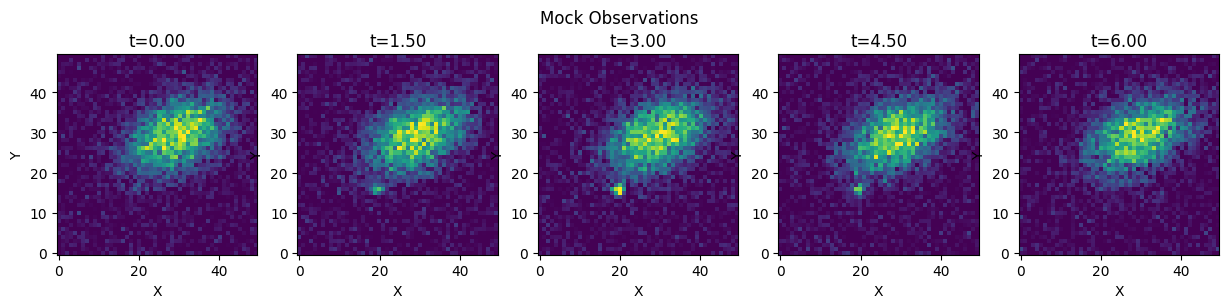

In [5]:
times = torch.linspace(0,6,Nobs)
data = torch.zeros((Nobs, imgsize, imgsize))
true_LC = SN_lightcurve.flux(times).detach().numpy()
torch.manual_seed(1123)  # For reproducibility
noise_sim = Noiser("noise_sim", sim, read_noise=sigma_read, exp_time= exp_time)
fig, axarr = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Mock Observations")
for i, t in enumerate(times):
    data[i] = noise_sim([t])
    axarr[i].imshow(data[i].detach().numpy(), origin="lower", vmin=0, vmax=1.5)
    axarr[i].set_title(f"t={t:.2f}")
    axarr[i].set_xlabel("X")
    axarr[i].set_ylabel("Y")
plt.show()

## Analysis starting point: Model each image individually

Let's imagine we are new to this problem and just starting out. We will make things simple and just analyze each image individually to construct our light curve. We are going to assume throughout that you know things like the read noise of your detector and the exposure time (which we are using as a basic noise model).

We will perform a straightforward likelihood analysis, thus our main goal will be to construct a likelihood.

In [6]:
class Likelihood(ck.Module):
    def __init__(self, name, model, data, sigma_read=0.05, exp_time=25):
        super().__init__(name)
        self.model = model
        self.data = data
        self.sigma_read = sigma_read
        self.exp_time = exp_time
        
    @ck.forward
    def residuals(self):
        model_output = self.model()
        variance = self.sigma_read**2 + model_output / self.exp_time 
        sigma = variance.sqrt()
        residuals = (self.data - model_output) / sigma
        return residuals, sigma

    @ck.forward
    def __call__(self): # log likelihood
        residuals, sigma = self.residuals()
        return -0.5 * (residuals ** 2).sum() - sigma.log().sum()

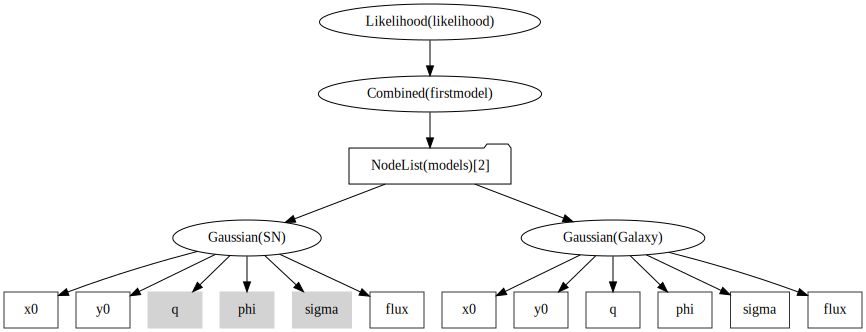

In [7]:
# Model
SNmodel = Gaussian("SN", x0=-0.35, y0=-0.2, q=1.0, phi=0.0, sigma=0.05, flux=0.2)
SNmodel.x0.to_dynamic() # "unknown" parameters
SNmodel.y0.to_dynamic()
SNmodel.flux.to_dynamic()
Galaxymodel = Gaussian("Galaxy", x0=0.2, y0=0.2, q=0.6, phi=0.5, sigma=0.3, flux=1.0)
Galaxymodel.to_dynamic() # "unknown" parameters
firstmodel = Combined("firstmodel", imgx, imgy, [SNmodel, Galaxymodel])
likelihood = Likelihood("likelihood", firstmodel, data[0], sigma_read=sigma_read, exp_time=exp_time)
likelihood.graphviz()

In [ ]:
light_curve_flux = []
light_curve_sigma = []
model_images = []
model_residuals = []
for i in range(Nobs):
    likelihood.data = data[i]  # Update the data for each observation

    # Fit the model
    x0 = likelihood.build_params_array()
    x0 += torch.randn_like(x0) * x0 * 0.05  # Add some noise to the initial guess since we cant start at the true values
    res = minimize(lambda x: -likelihood(torch.tensor(x)).numpy(), x0, method='Nelder-Mead')
    light_curve_flux.append(res.x[2])

    # Get uncertainty using inverse Hessian
    hess = -hessian(likelihood, torch.tensor(res.x), strict=True)
    hess_inv = torch.linalg.inv(hess)
    light_curve_sigma.append(hess_inv[2,2].abs().sqrt().item())

    # Store model images and residuals
    model_images.append(firstmodel(torch.tensor(res.x)).detach().numpy())
    model_residuals.append(likelihood.residuals(torch.tensor(res.x))[0].detach().numpy())

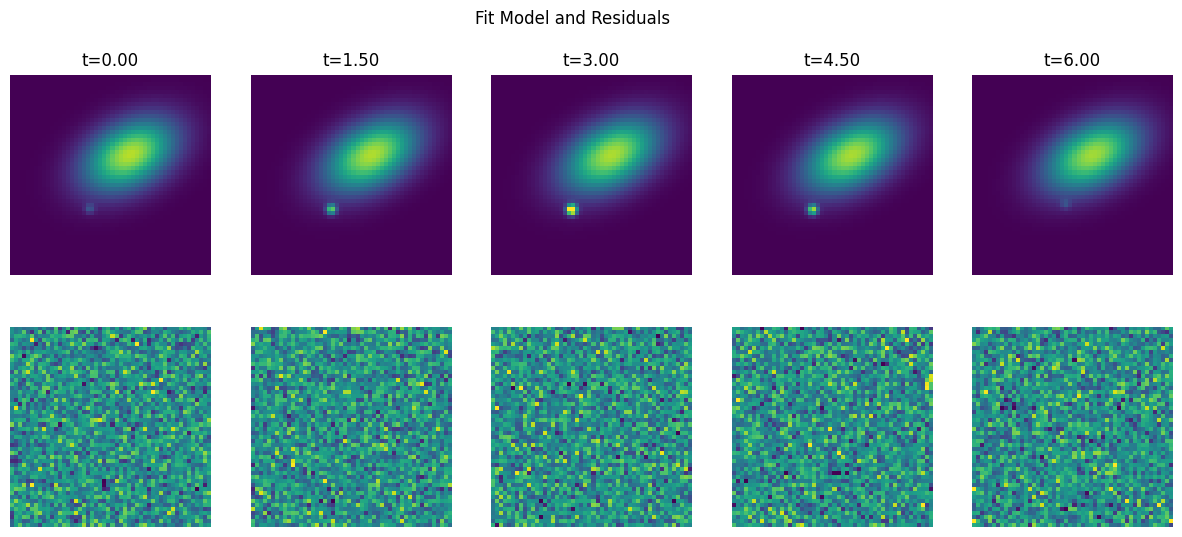

In [9]:
fig, axarr = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Fit Model and Residuals")
for i in range(Nobs):
    axarr[0][i].imshow(model_images[i], origin="lower", vmin=0, vmax=1.5)
    axarr[0][i].set_title(f"t={times[i]:.2f}")
    axarr[0][i].axis("off")
    axarr[1][i].imshow(model_residuals[i], origin="lower", vmin=-3, vmax=3)
    axarr[1][i].axis("off")
plt.show()

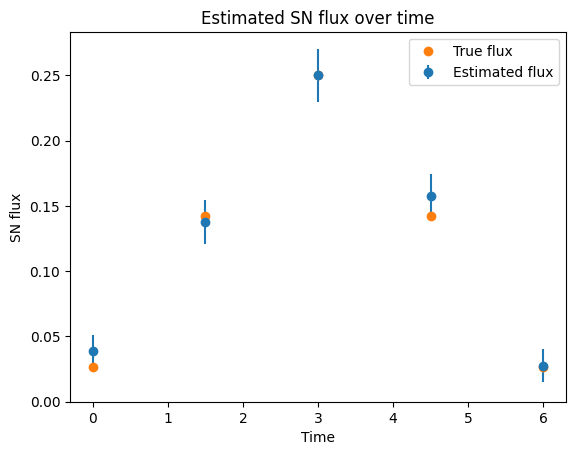

In [10]:
plt.errorbar(times.numpy(), light_curve_flux, yerr=light_curve_sigma, fmt='o', label='Estimated flux')
plt.plot(times.numpy(), true_LC, 'o', label='True flux')
plt.xlabel('Time')
plt.ylabel('SN flux')
plt.ylim(0,None)
plt.title('Estimated SN flux over time')
plt.legend()
plt.show()

This is our first go at measuring the light curve. It mostly looks like what we should expect, the bright points are fit well but the faint ones fail and we get no meaningful flux estimate from them. For the very faint SN images, it is hard to see in the noise where the SN even is, let alone determine its flux. So next lets see if we can add some complexity to our model and get better results!

## Analysis Improvement: Joint modelling

We don't need to analyze each image individually, we have some knowledge of how these SN should look in our data. For example, the position of the SN and galaxy should be constant with time, further, the galaxy should really be fixed over time, the only thing that changes is the SN flux, so lets encode that in our analysis.

`caksade` lets us fix parameters to match each other, so we will make a model for each image then link the parameters accordingly to the first image model. This way our parameter vector will only include what's needed to model the full set of images. We also create a wrapper module to stack the results from all the models so it can easily be passed to the likelihood.

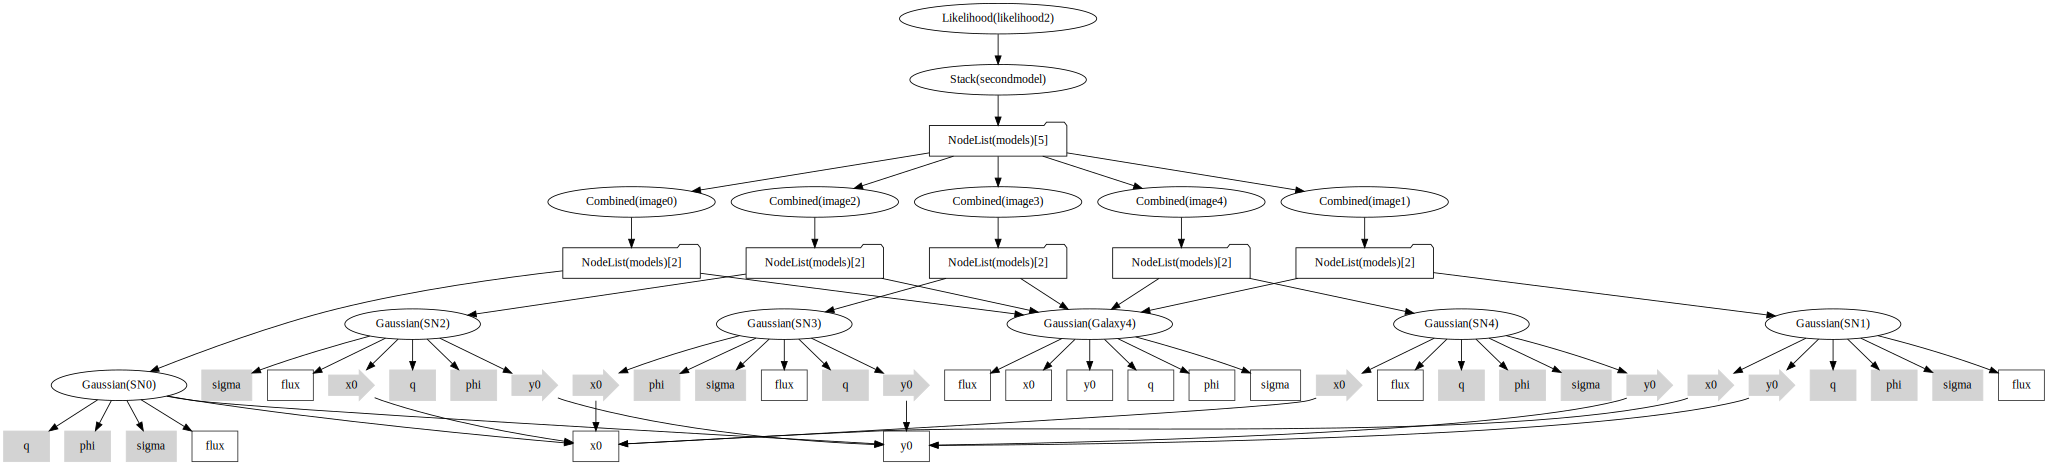

In [11]:
# One galaxy model since it does not change across images
Galaxymodel = Gaussian(f"Galaxy{i}", x0=0.2, y0=0.2, q=0.6, phi=0.5, sigma=0.3, flux=1.0)
Galaxymodel.to_dynamic() # "unknown" parameters

imgmodels = []
for i in range(Nobs):
    SNmodel = Gaussian(f"SN{i}", x0=-0.35, y0=-0.2, q=1.0, phi=0.0, sigma=0.05, flux=0.2)
    SNmodel.x0.to_dynamic() # "unknown" parameters
    SNmodel.y0.to_dynamic()
    SNmodel.flux.to_dynamic()
    imgmodel = Combined(f"image{i}", imgx, imgy, [SNmodel, Galaxymodel])
    imgmodels.append(imgmodel)
    if i > 0: # SN position doesnt change across images
        SNmodel.x0 = imgmodels[0].models[0].x0
        SNmodel.y0 = imgmodels[0].models[0].y0

class Stack(ck.Module):
    def __init__(self, name, models):
        super().__init__(name)
        self.models = models

    @ck.forward
    def __call__(self):
        return torch.stack([model() for model in self.models], dim=0)
secondmodel = Stack("secondmodel", imgmodels)
likelihood2 = Likelihood("likelihood2", secondmodel, data, sigma_read=sigma_read, exp_time=exp_time)
likelihood2.graphviz()

In [12]:
# Fit light curve
x0 = likelihood2.build_params_array()
x0 += torch.randn_like(x0) * x0 * 0.05  # Add some noise to the initial guess since we cant start at the true values
res = minimize(lambda x: -likelihood2(torch.tensor(x)).numpy(), x0, method='Nelder-Mead')

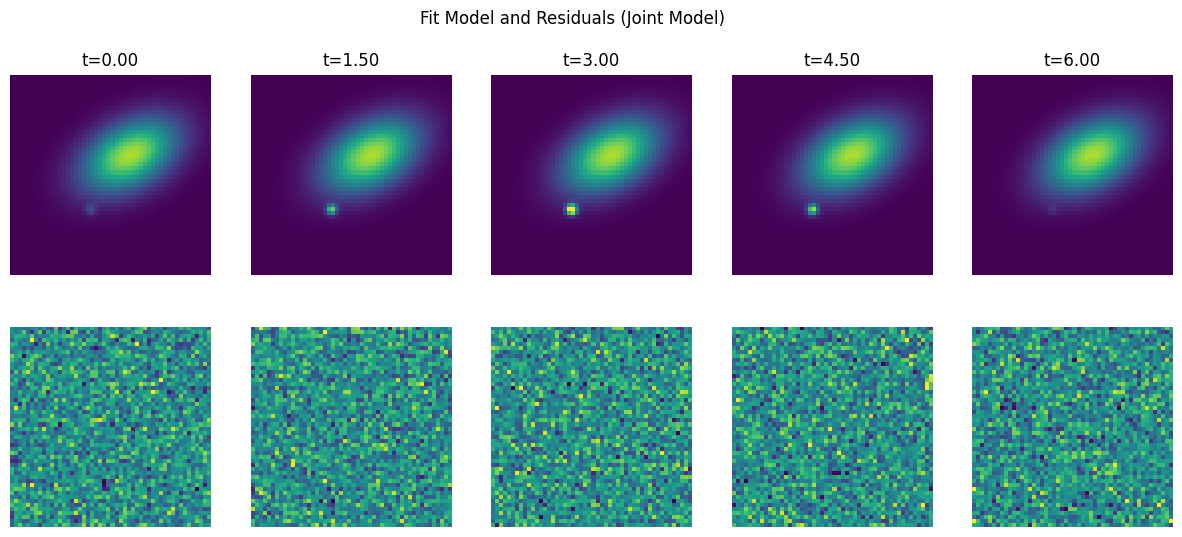

In [13]:
fig, axarr = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Fit Model and Residuals (Joint Model)")
model_imgs = secondmodel(torch.tensor(res.x))
residuals = likelihood2.residuals(torch.tensor(res.x))[0]
for i in range(Nobs):
    axarr[0][i].imshow(model_imgs[i].detach().numpy(), origin="lower", vmin=0, vmax=1.5)
    axarr[0][i].set_title(f"t={times[i]:.2f}")
    axarr[0][i].axis("off")
    axarr[1][i].imshow(residuals[i].detach().numpy(), origin="lower", vmin=-3, vmax=3)
    axarr[1][i].axis("off")
plt.show()

In [ ]:
# extract light curve
likelihood2.fill_dynamic_values(torch.tensor(res.x))
likelihood2.to_static(local_only=False)
light_curve_flux = []
light_curve_sigma = []
for model in secondmodel.models:
    light_curve_flux.append(model.models[0].flux.value.item())
    model.models[0].flux.to_dynamic()
    
# Compute uncertainty using inverse Hessian
hess = -hessian(likelihood2, likelihood2.build_params_array(), strict=True)
hess_inv = torch.linalg.inv(hess)  # Invert the Hessian to get the covariance matrix
light_curve_sigma = torch.sqrt(torch.diag(hess_inv)).numpy()

Estimated light curve fluxes: [0.03493320569396019, 0.13849201798439026, 0.2536572813987732, 0.15727443993091583, 0.013588673435151577]
Estimated light curve uncertainties: [nan nan nan nan nan]


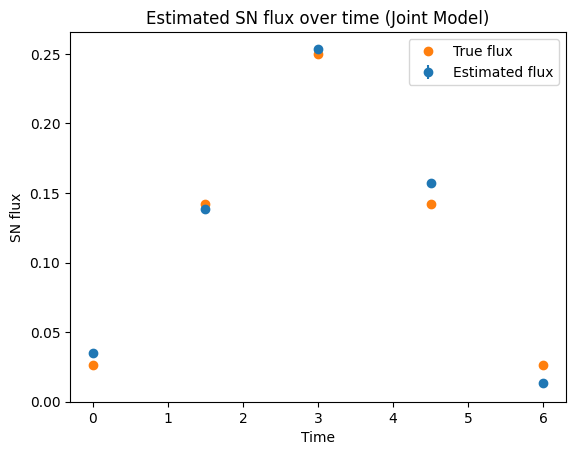

In [15]:
print("Estimated light curve fluxes:", light_curve_flux)
print("Estimated light curve uncertainties:", light_curve_sigma)
plt.errorbar(times.numpy(), light_curve_flux, yerr=light_curve_sigma, fmt='o', label='Estimated flux')
plt.plot(times.numpy(), true_LC, 'o', label='True flux')
plt.xlabel('Time')
plt.ylabel('SN flux')
plt.ylim(0,None)
plt.title('Estimated SN flux over time (Joint Model)')
plt.legend()
plt.show()

Clearly this is much more stable than fitting each image individually. The faint times of the SN lightcurve are very hard to find in the data, but using the position from the bright times we can lock it in so that we have a good position at all times, once the position is determined it is possible to measure the flux even though it is faint!

## Analysis Improvement: Functional Light Curve

We know the function for the light curve, it is a Gaussian in time (for this mock data at least), so we can encode that knowledge into our simulator by making the SN flux dependent on that function rather than a free parameter. What's incredible is that we can simply reuse the previous model and tack on a new function of time to control the fluxes of the SN, no need to modify any of the previous code!

In [16]:
# re-set appropriate parameters to dynamic again
secondmodel.models[0].models[1].to_dynamic()  # make galaxy model dynamic
secondmodel.models[0].models[0].x0.to_dynamic()  # make SN position dynamic
secondmodel.models[0].models[0].y0.to_dynamic()

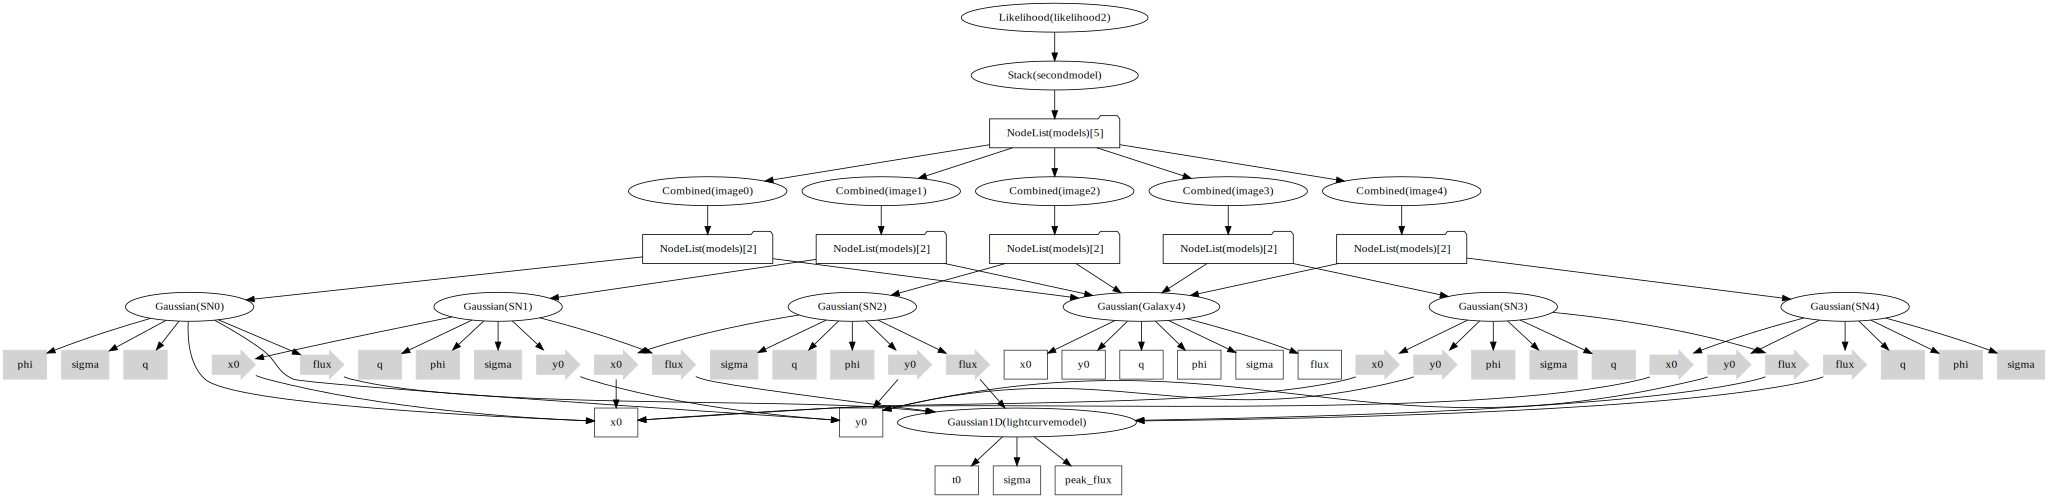

In [17]:
# Add light curve model to control the fluxes
lightcurvemodel = Gaussian1D("lightcurvemodel", t0=-3.0, sigma=2.5, peak_flux=0.25)
lightcurvemodel.to_dynamic()
for i in range(Nobs):
    secondmodel.models[i].models[0].flux = lambda p: p.lightcurvemodel.flux(t=p.eval_t)
    secondmodel.models[i].models[0].flux.link(lightcurvemodel)
    secondmodel.models[i].models[0].flux.eval_t = times[i].clone()
likelihood2.graphviz()

Take a moment to appreciate the complexity of this model despite very little work on our part or alteration of our original gaussian light model. For the supernovae, they all share a position but each flux is a function of a light curve model evaluated at different times. We fixed the sigma for the SN assuming we knew the PSF but we could just as easily set it to dynamic and now we would be fitting the PSF width alongside all the other parameters! The galaxy is more straightforward, since all parameters are held constant, but consider that we didn't need to modify our gaussian or likelihood code to enforce this, we did it by linking parameters, so we didn't need to rewrite our likelihood or gaussian models and could reuse them for other models/projects!

In [18]:
# Fit light curve
x0 = likelihood2.build_params_array()
x0 += torch.randn_like(x0) * x0 * 0.05  # Add some noise to the initial guess since we cant start at the true values
res = minimize(lambda x: -likelihood2(torch.tensor(x)).numpy(), x0, method='Nelder-Mead')

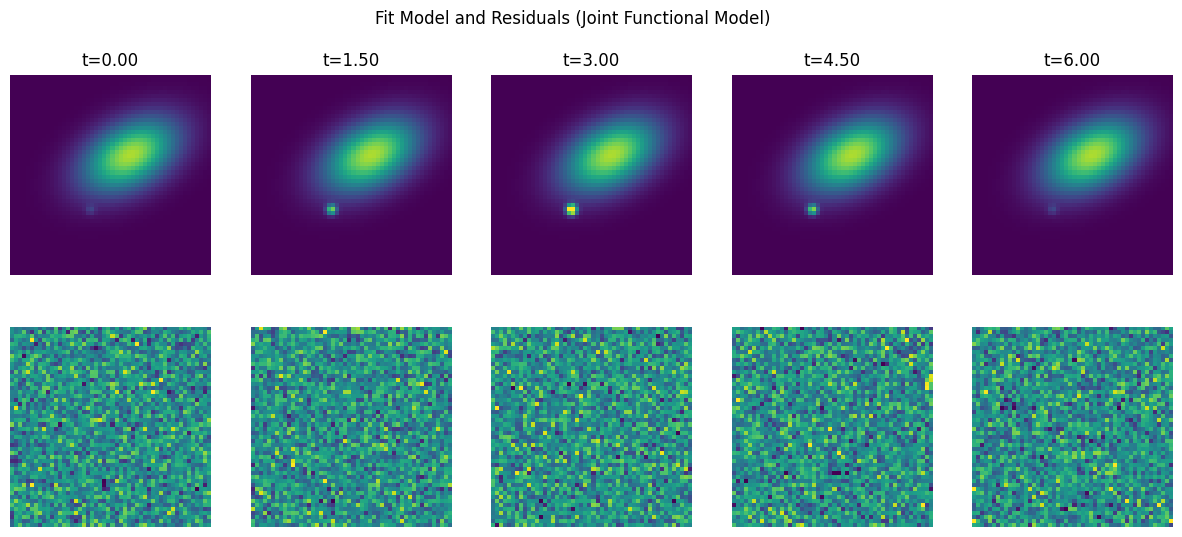

In [19]:
fig, axarr = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Fit Model and Residuals (Joint Functional Model)")
model_imgs = secondmodel(torch.tensor(res.x))
residuals = likelihood2.residuals(torch.tensor(res.x))[0]
for i in range(Nobs):
    axarr[0][i].imshow(model_imgs[i].detach().numpy(), origin="lower", vmin=0, vmax=1.5)
    axarr[0][i].set_title(f"t={times[i]:.2f}")
    axarr[0][i].axis("off")
    axarr[1][i].imshow(residuals[i].detach().numpy(), origin="lower", vmin=-3, vmax=3)
    axarr[1][i].axis("off")
plt.show()

In [20]:
# extract light curve
likelihood2.fill_dynamic_values(torch.tensor(res.x))
light_curve_flux = []
light_curve_sigma = []
for model in secondmodel.models:
    light_curve_flux.append(model.models[0].flux.value.item())

Estimated light curve fluxes: [0.02484535053372383, 0.14358696341514587, 0.2610667049884796, 0.14933258295059204, 0.026873502880334854]


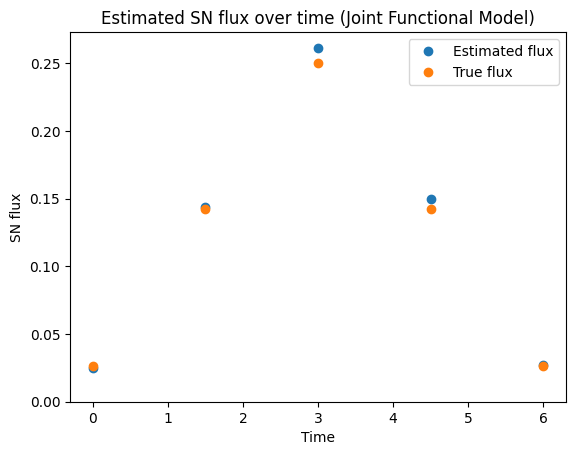

In [21]:
print("Estimated light curve fluxes:", light_curve_flux)
plt.plot(times.numpy(), light_curve_flux, 'o', label='Estimated flux', markersize = 6)
plt.plot(times.numpy(), true_LC, 'o', label='True flux')
plt.xlabel('Time')
plt.ylabel('SN flux')
plt.ylim(0,None)
plt.title('Estimated SN flux over time (Joint Functional Model)')
plt.legend()
plt.show()

Now we do even better! Since we know the form of the light curve, that gives us extra constraining power. Instead of fitting 5 fluxes, we now fit the three `t0`, `sigma`, `peak_flux` parameters and so we get even better results. 

In [22]:
likelihood2.to_static(False)
lightcurvemodel.to_dynamic()
fit_vals = likelihood2.build_params_array()
hess = -hessian(likelihood2, fit_vals, strict=True)
hess_inv = torch.linalg.inv(hess)  # Invert the Hessian to get the covariance matrix
light_curve_sigma = torch.sqrt(torch.diag(hess_inv).abs()).numpy()
print(f"Light Curve t0: {fit_vals[0].item():.2f} ± {light_curve_sigma[0]:.2f} vs {SN_lightcurve.t0.value.item():.2f} (true)")
print(f"Light Curve sigma: {fit_vals[1].item():.2f} ± {light_curve_sigma[1]:.2f} vs {SN_lightcurve.sigma.value.item():.2f} (true)")
print(f"Light Curve peak flux: {fit_vals[2].item():.3f} ± {light_curve_sigma[2]:.3f} vs {SN_lightcurve.peak_flux.value.item():.3f} (true)")

Light Curve t0: -3.03 ± 0.09 vs -3.00 (true)
Light Curve sigma: 1.97 ± 0.12 vs 2.00 (true)
Light Curve peak flux: 0.261 ± 0.018 vs 0.250 (true)


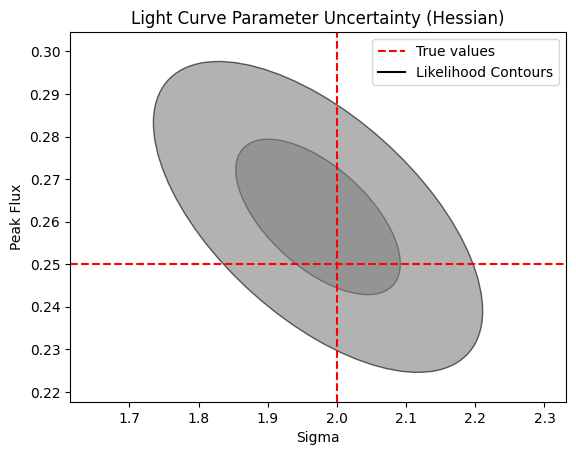

In [23]:
fig, ax = plt.subplots()
ax.axvline(SN_lightcurve.sigma.value.item(), color='r', linestyle='--', label='True values')
ax.axhline(SN_lightcurve.peak_flux.value.item(), color='r', linestyle='--')
ax.set_xlabel("Sigma")
ax.set_ylabel("Peak Flux")
lambda_, v = np.linalg.eig(hess_inv[1:, 1:])
lambda_ = np.sqrt(lambda_)
angle = np.rad2deg(np.arctan2(v[1, 0], v[0, 0]))
for k in [1, 2]:
    ellipse = Ellipse(
        xy=(fit_vals[1].item(), fit_vals[2].item()),
        width=lambda_[0] * k * 2,
        height=lambda_[1] * k * 2,
        angle=angle,
        edgecolor="black",
        facecolor="grey",
        alpha=0.6,
    )
    ax.add_artist(ellipse)
plt.plot([],[], c="k", label="Likelihood Contours")
ax.set_xlim(fit_vals[1].item() - lambda_[0] * 3, fit_vals[1].item() + lambda_[0] * 3)
ax.set_ylim(fit_vals[2].item() - lambda_[1] * 3, fit_vals[2].item() + lambda_[1] * 3)
ax.set_title("Light Curve Parameter Uncertainty (Hessian)")
ax.legend()
plt.show()

In [24]:
# re-set appropriate parameters to dynamic again
secondmodel.models[0].models[1].to_dynamic()  # make galaxy model dynamic
secondmodel.models[0].models[0].x0.to_dynamic()  # make SN position dynamic
secondmodel.models[0].models[0].y0.to_dynamic()

### Sampling vs Optimizing

`caskade` turns our simulator and likelihood into simple functions of a 1D vector, we can use other packages besides `scipy.optimize.minimize` to analyze our data now. Here we try the `emcee` package for MCMC sampling.

In [25]:
vsim = torch.vmap(likelihood2)

# Log-likelihood function
def density(x):
    return vsim(torch.as_tensor(x, dtype=torch.float32)).numpy()

x0 = likelihood2.build_params_array()
nwalkers = 32
ndim = len(x0)

sampler = emcee.EnsembleSampler(nwalkers, ndim, density, vectorize=True)

x0 = x0 * (1 + 0.1 * torch.randn(nwalkers, ndim, dtype=torch.float32))
print("burn-in")
state = sampler.run_mcmc(x0, 100, skip_initial_state_check=True)  # burn-in
sampler.reset()
print("production")
state = sampler.run_mcmc(state, 1000)  # production

burn-in
production


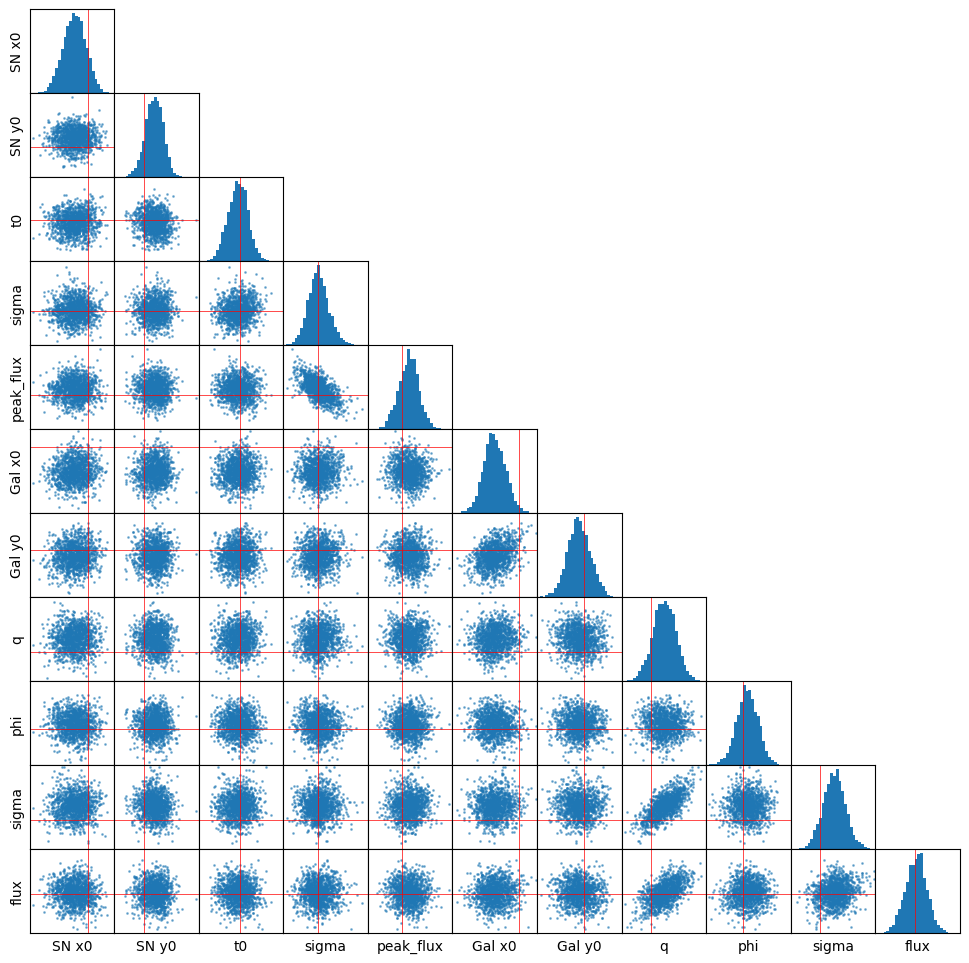

In [45]:
SN_lightcurve.to_dynamic()
Galaxy.to_dynamic()
true_values = [SN.x0.value.item(), SN.y0.value.item()] + list(SN_lightcurve.build_params_array().numpy()) + list(Galaxy.build_params_array().numpy())
chain_mh = sampler.get_chain(flat=True)
fig, axarr = plt.subplots(ndim, ndim, figsize=(12, 12))
plt.subplots_adjust(hspace=0., wspace=0.)
labels = list(p.name for p in likelihood2.dynamic_params)
labels[0] = "SN x0"
labels[1] = "SN y0"
labels[5] = "Gal x0"
labels[6] = "Gal y0"
for i in range(ndim):
    for j in range(ndim):
        if j > i:
            axarr[i, j].axis("off")
            continue
        axarr[i, j].axvline(true_values[j], color='r', label='True value', linewidth=0.5)
        axarr[i,j].set_xlim(chain_mh[:, j].min(), chain_mh[:, j].max())
        if i == j:
            axarr[i, j].hist(chain_mh[:, i], bins=30, density=True)
        else:
            axarr[i, j].scatter(chain_mh[:, j][::25], chain_mh[:, i][::25], s=1, alpha=0.5)
            axarr[i,j].axhline(true_values[i], color='r', label='True value', linewidth=0.5)
            axarr[i,j].set_ylim(chain_mh[:, i].min(), chain_mh[:, i].max())

        if j == 0:
            axarr[i, j].set_ylabel(f"{labels[i]}")
        if i == ndim-1:
            axarr[i, j].set_xlabel(f"{labels[j]}")
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])
plt.show()

## End note

Now we are at the end you might think to yourself "wouldn't it have been easier to just write the final model directly rather than using caskade?" And in a sense you are right. One could probably sit down and write this model out as a single class or a small series of functions. The problem is that science is an iterative process and you will likely not begin your project by simply sitting down and writing a complete model of every feature in your data. You will experiment, and break things, and increase complexity, and backtrack, and change goals, and so on as the project changes in scope and the objective becomes clearer. What `caskade` really accomplishes is letting you do all that iteration quickly, without re-writing each time, in a less error prone way, letting you see changes visually in the graph, and letting a project grow in scale naturally. `caskade` is built for the scientific development process, and those who use it don't turn back. 